# Multiple Linear Regression

So far we've seen how to model a linear relationship between one feature and the target. However, the real world is much more complicated and it is possible that your target is dependent upon multiple features. For example, in the `carseat` data we previously examined, `Sales` is probably dependent on more than just the `Price` of the carseat, or at least the people in the marketing department think so.

## What We'll Accomplish in This Notebook

In this notebook we'll look at the following:

<ul>
    <li>How the setup for linear regression changes when we go from a single feature to multiple features</li> 
    <li>How to incorporate multiple continuous features into linear regression by predicting sales from ad buys,</li> 
    <li>How to incorporate qualitative features into linear regression through one-hot encoding to predict beer IBU,</li> 
    <li>How to select the best subset of predictors with cross-validation,</li> 
    <li>Building the best carseat Sales Predictor we can.</li>
</ul>

In [1]:
# import the packages we'll use


## For data handling
import pandas as pd
import numpy as np

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## What Changes Going From One Predictor to Many?

### The Statistical Model

As always assume the data consists of $n$ observations.

Recall that the simple linear regression statistical model is:
$$
y = \beta_0 + \beta_1 X + \epsilon,
$$
where $y$ was your target vector, $X$ a vector of values for a single feature, and $\epsilon$ is a vector of independent $\epsilon_i \sim N(0,\sigma^2)$ for all $i$. 

Now for multiple linear regression let's say you have $m$ features you want to use to predict $y$. Then the model becomes:
$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_m X_m + \epsilon ,
$$
where $X_1,X_2,\dots,X_m$ are the $m$ features, and $\epsilon$ is the same as in SLR. If we collect all of the features as a single column along with a column of $1$s in a larger feature matrix,
$$
X = \left(\begin{array}{c | c | c | c | c}
    1 & X_1 & X_2 & \dots & X_m
\end{array}\right),
$$
and let $\beta=\left(\beta_0, \beta_1, \beta_2,\dots,\beta_m\right)^T$ then the statistical model for MLR becomes:
$$
y = X\beta + \epsilon.
$$

We're still making all of the same assumptions as in SLR, but now $y$ is a linear function of $m$ predictors instead of just $1$. 

### Estimating the Model

When it comes to estimating $\beta$ we can get away with just using the `sklearn` shortcut we learned in SLR I in practice. However, let's show the formula for the estimate $\hat{\beta}$ so we can get behind the black box nature of `sklearn`.

#### Minimizing MSE

We again set out to minimize the MSE
$$
MSE = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y_i} \right)^2 = \frac{1}{n} \sum_{i=1}^n \left( y_i - X_{i,\bullet} \hat{\beta} \right)^2
$$
You can use some rewriting, linear algebra, and matrix differentiation to come up with the following OLS estimate for $\beta$,
$$
\hat{\beta} = (X^TX)^{-1}X^Ty.
$$
This is the estimate of $\beta$ that minimizes the MSE, you may hear people refer to this as the normal equation or the Ordinary Least Squares (OLS) Solution.

## Question Break

Before we move onto putting MLR in action we'll pause for one or two questions, or just so you can shut off your brain for a couple minutes. I'll announce when we're moving on.

<br>
<br>
<br>
<br>
<br>

## Break Over

## Predicting Sales Based on Ad Buys

Now that we understand the MLR setup. Let's use it to predict sales given how much money was spent on various advertising mediums. The data is stored in `Advertising.csv`.

In [2]:
# Read in the data
ads = pd.read_csv("Advertising.csv")

print("There are", len(ads), "observations in the data set.")
print("The columns are", ads.columns)

There are 200 observations in the data set.
The columns are Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')


In [3]:
# Make the train test split
ads_copy = ads.copy()

# Set aside 25% of the data
# make 614 the random_state because I live in Columbus
ads_train = ads_copy.sample(frac = .75, random_state = 614)
ads_test = ads_copy.drop(ads_train.index)

In [4]:
# examine training head
ads_train.head()

,TV,radio,newspaper,sales
193,166.8,42.0,3.6,19.6
142,220.5,33.2,37.9,20.1
78,5.4,29.9,9.4,5.3
37,74.7,49.4,45.7,14.7
153,171.3,39.7,37.7,19.0


This data set came from the book, <a href="http://faculty.marshall.usc.edu/gareth-james/ISL/">Introduction to Statistical Learning</a>, by  Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. 

The data can be found here, <a href="http://faculty.marshall.usc.edu/gareth-james/ISL/data.html">http://faculty.marshall.usc.edu/gareth-james/ISL/data.html</a>.

How can we decide which predictors to include? We'll dive more into model selection later in the notebook, for now let's look at what features have the strongest correlation with `sales`. 

In [5]:
ads_train.corr()['sales'].sort_values()

newspaper    0.270427
radio        0.621664
TV           0.787856
sales        1.000000
Name: sales, dtype: float64

It looks like `radio` and `TV` are the most promising when it comes to having a linear relationship. Both have relatively strong positive linear relationships according to the Pearson correlation. In addition to examining $\rho$, this data set has so few features we can produce what is called a scatter matrix.

In [6]:
# scatter matrix makes a matrix of scatter plots
from pandas.plotting import scatter_matrix

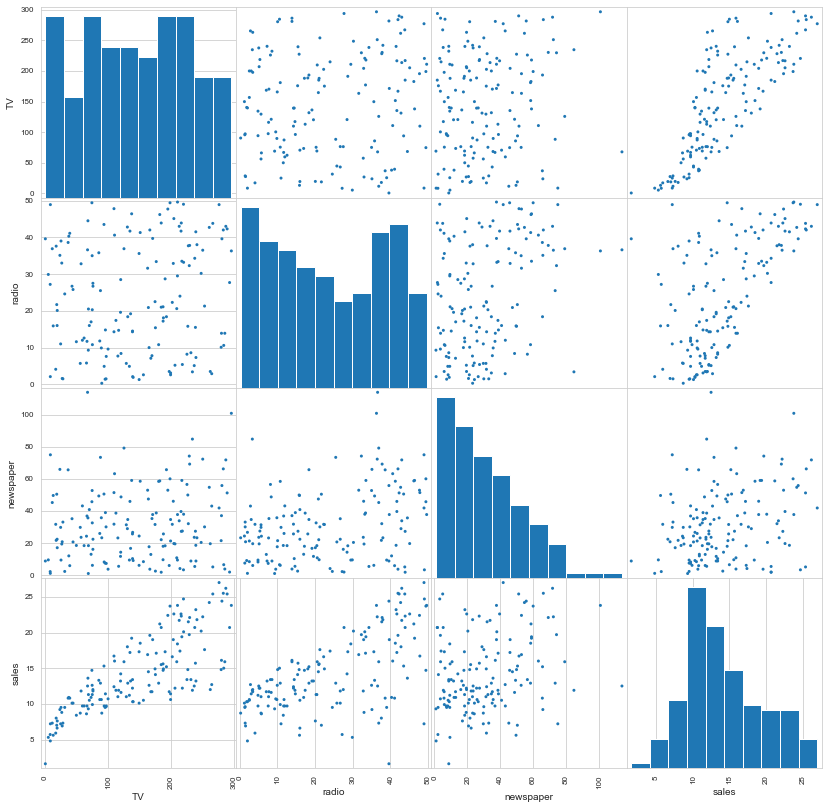

In [7]:
# first input the dataframe you want to see a 
# scatter matrix for
# then enter figsize and other plotting arguments
scatter_matrix(ads_train, figsize = (14,14), alpha = 1)

plt.show()

There definitely appears to be some relationship between `sales` and `TV` as well as `sales` and `radio`. For now we'll treat these as linear relationships, although stay tuned for Notebook 4.

It seems that a reasonable starting model would be
$$
\text{sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{radio} + \epsilon
$$
Let's fit the coefficients using the formula we just learned before diving into the `sklearn` toolbox.

In [8]:
# make X
X = np.ones([len(ads_train),3])
X[:,1] = np.array(ads_train.TV)
X[:,2] = np.array(ads_train.radio)

# Make y
y = np.array(ads_train.sales)

# Calculate beta_hat
beta_hat = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

In [9]:
print("beta_0_hat is",np.round(beta_hat[0],5))
print("beta_1_hat is",np.round(beta_hat[1],5))
print("beta_2_hat is",np.round(beta_hat[2],5))
#print("beta_3_hat is",np.round(beta_hat[3],5))

beta_0_hat is 2.89888
beta_1_hat is 0.04645
beta_2_hat is 0.19091


#### Verifying with `sklearn`

Let's demonstrate how to do this with `sklearn` as well.

In [10]:
# import the LinearRegression model class
from sklearn.linear_model import LinearRegression

In [11]:
# Make the model object
reg = LinearRegression(copy_X = True)

In [12]:
# Fit the data
reg.fit(ads_train[['TV','radio']],ads_train['sales'])

# Note you could also use the np arrays we built
# be sure to only include the non-1s columns
# reg.fit(X[:,1:3],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))

beta_0_hat is 2.89888
beta_1_hat is 0.04645
beta_2_hat is 0.19091


In [14]:
# We can use sklearn to make a prediction on the
# training data as well
pred = reg.predict(ads_train[['TV','radio']])

#### A Slight Change in Interpretation

We can still interpret the fit, but the specific details are slightly different. Let's interpret $\hat{\beta_1}$, this has been estimated as $0.04645$. We can interpret this as:

<i>for a $1$ unit increase in TV holding all other variables constant, we estimate a $0.04645$ increase in sales.</i>



### Plotting the Regression

This is more difficult with multiple features. Because we only have two features we can make a $3$-D plot like so.

In [15]:
# get the prediction this is where meshgrid comes in handy
x1s = np.linspace(ads_train.TV.min(), ads_train.TV.max(), 10)
x2s = np.linspace(ads_train.radio.min(), ads_train.radio.max(), 10)

# this makes a meshgrid
x1v, x2v = np.meshgrid(x1s, x2s)

# combine x1v and x2v into a single array for prediction
X_grid = np.concatenate([x1v.reshape(-1,1), x2v.reshape(-1,1)], axis=1)

# predict at each grid point
pred_grid = reg.predict(X_grid)

# add the predictions to the grid array
X_grid = np.concatenate([X_grid, pred_grid.reshape(-1,1)], axis=1)

<IPython.core.display.Javascript object>


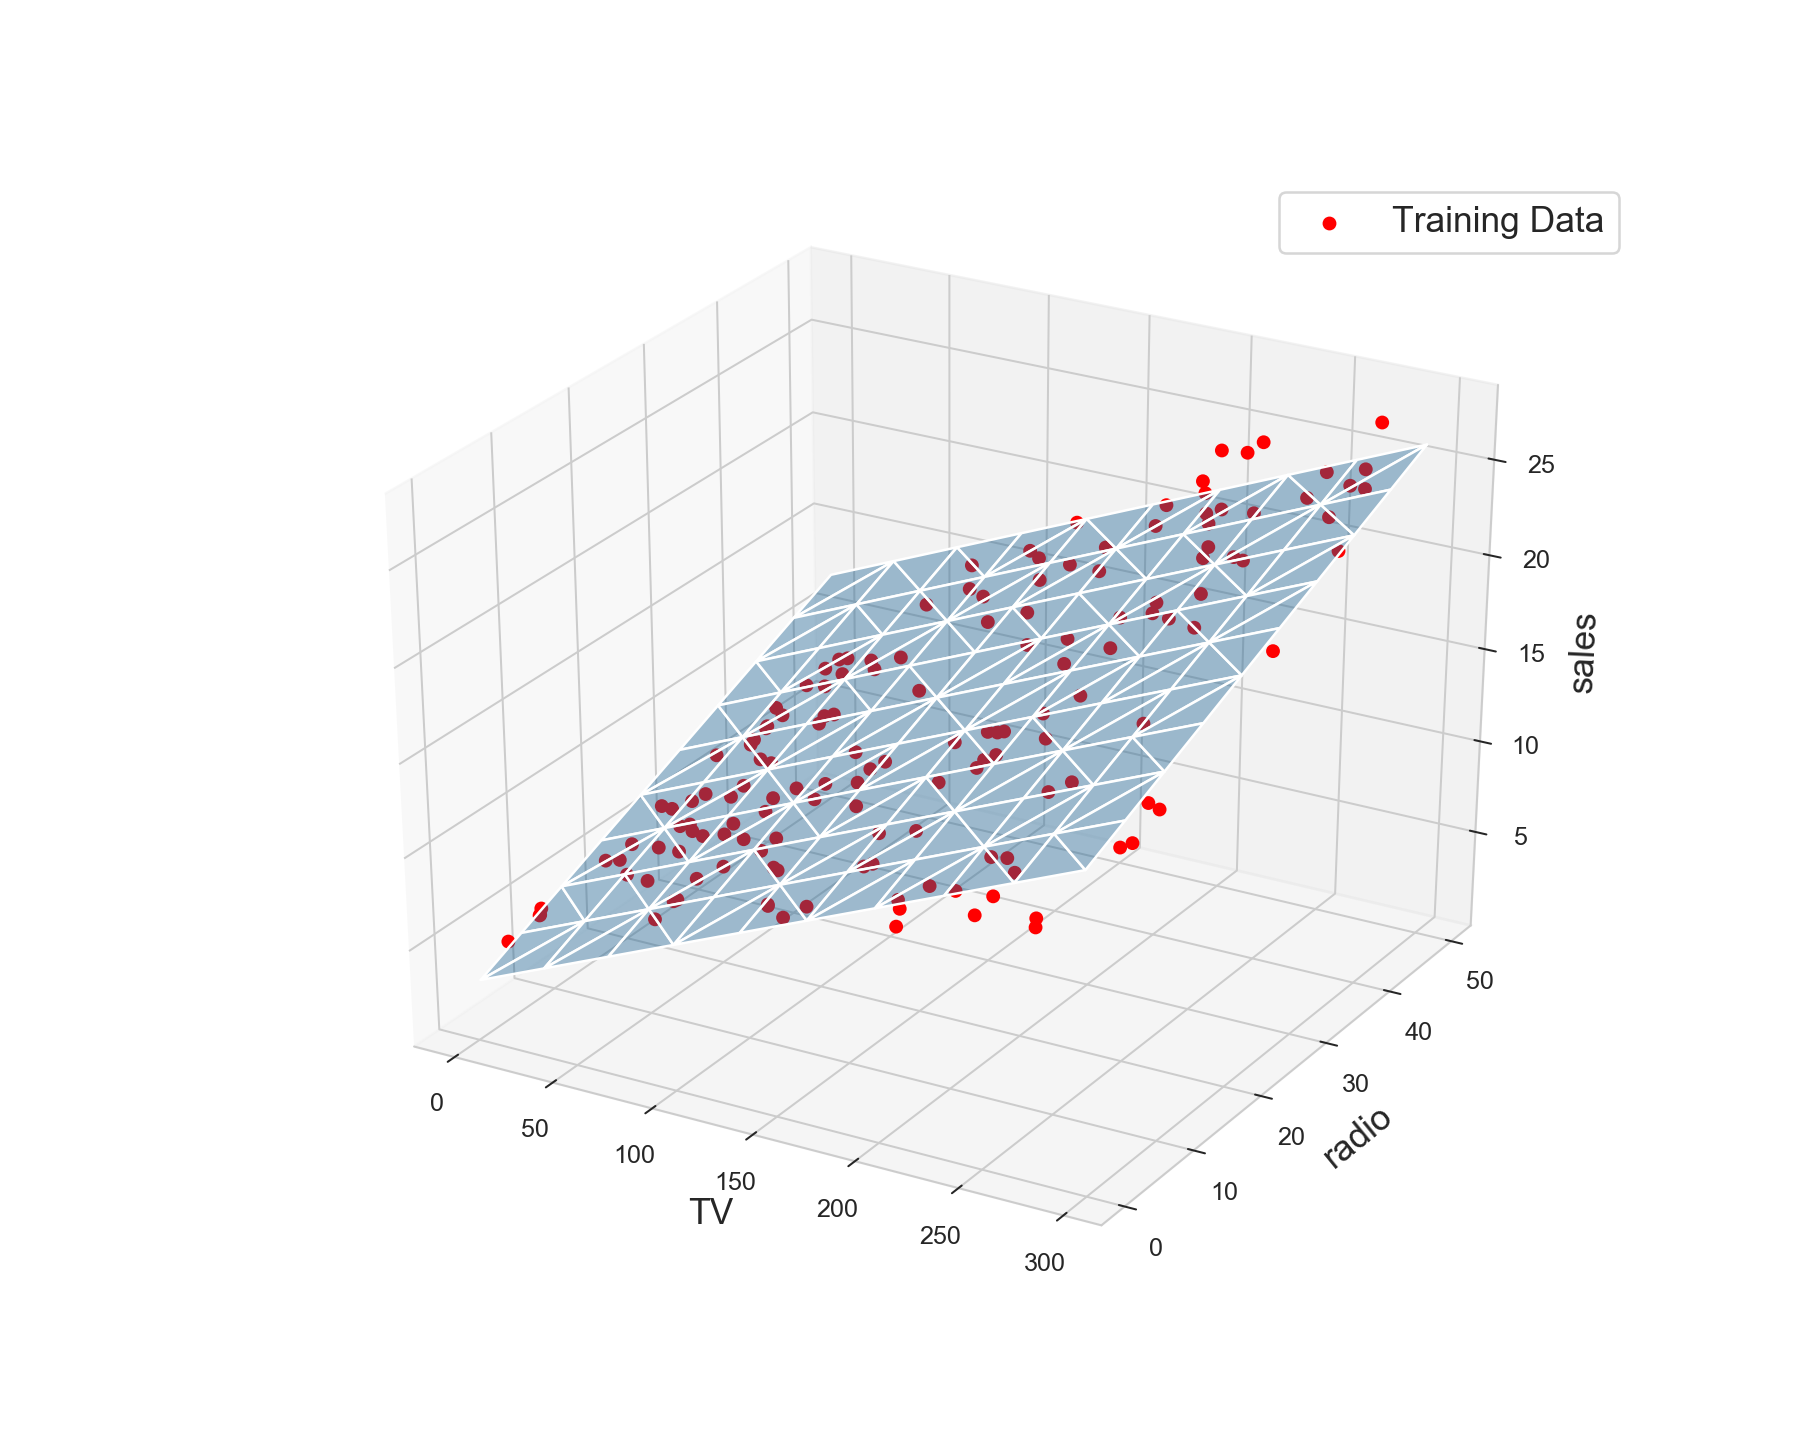

In [16]:
%matplotlib notebook
# Now we plot the regression plane
# along with the training observations

# Make a figure object
fig = plt.figure(figsize=(10,8))

# We'll add a 3d subplot object
ax = fig.add_subplot(111, projection='3d')

# plot_trisurf makes a surface out of triangles
# it will take in the TV grid on the x-axis
# the radio grid on the y-axis
# and the prediction grid on the z-axis
# alpha <1 allows us to see through the surface
ax.plot_trisurf(X_grid[:, 0], X_grid[:, 1], X_grid[:,2], alpha=0.4)

# scatter will plot the observations from the training set
ax.scatter(ads_train['TV'], ads_train['radio'], ads_train['sales'], c="r", alpha=1, label="Training Data")

# Add labels
ax.set_xlabel("TV", fontsize=14)
ax.set_ylabel("radio", fontsize=14)
ax.set_zlabel("sales", fontsize=14)

plt.legend(fontsize=14)

plt.show()

You can rotate the plot and examine how well we fit the data with our model. As you rotate it does seem like the residuals may not be random, so perhaps our model was not the best choice. We'll examine this more closely in Notebook 4 when we introduce transformations of features and interaction terms.

## Questions

Let's take one or two questions then go off to a breakout room and practice.

<br>
<br>
<br>
<br>
<br>

## End Questions

## Practice

Return once again to the `carseats` data set. Examine the continuous features using correlations and scatter plots and produce a MLR model to predict `Sales`. Just use your best judgement, it's okay if you don't produce the best model right now. We will be touching on model selection later in the notebook.

Note you can read about the variables in `carseats` here, <a href="https://rdrr.io/cran/ISLR/man/Carseats.html">https://rdrr.io/cran/ISLR/man/Carseats.html</a>.

In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















## Dealing with Qualitative Predictors with Beer Data

Now that we have a grasp of how MLR works with continuous predictors let's examine how we can also include qualitative predictors like binary or categorical features.

To do this we'll look at `beer.csv`, our goal is to build a model that predicts `IBU`.

In [17]:
# Read in the csv
beers = pd.read_csv("beer.csv")

print("There are", len(beers), "observations in the data set.")
print("The columns are", beers.columns)

# Check the percentage of each Beer_Type to
# see if we need to stratify our train test split
beers.Beer_Type.value_counts(normalize=True)

There are 347 observations in the data set.
The columns are Index(['Beer_Name', 'IBU', 'ABV', 'Rating', 'Beer_Type'], dtype='object')


IPA      0.56196
Stout    0.43804
Name: Beer_Type, dtype: float64

In [18]:
# train test split
beers_copy = beers.copy()

beers_train = beers_copy.sample(frac=.75,random_state = 614)
beers_test = beers_copy.drop(beers_train.index)

In [19]:
# Sanity check to see our percentages are close 
# to the same as the original
beers_train.Beer_Type.value_counts(normalize=True)

IPA      0.557692
Stout    0.442308
Name: Beer_Type, dtype: float64

### Why Add Qualitative Data to Regression

Now why might we want to add in this qualitative data? Because it can add more context. Let's use `seaborn`'s `lmplot` to demonstrate with the `beer` data.

<IPython.core.display.Javascript object>


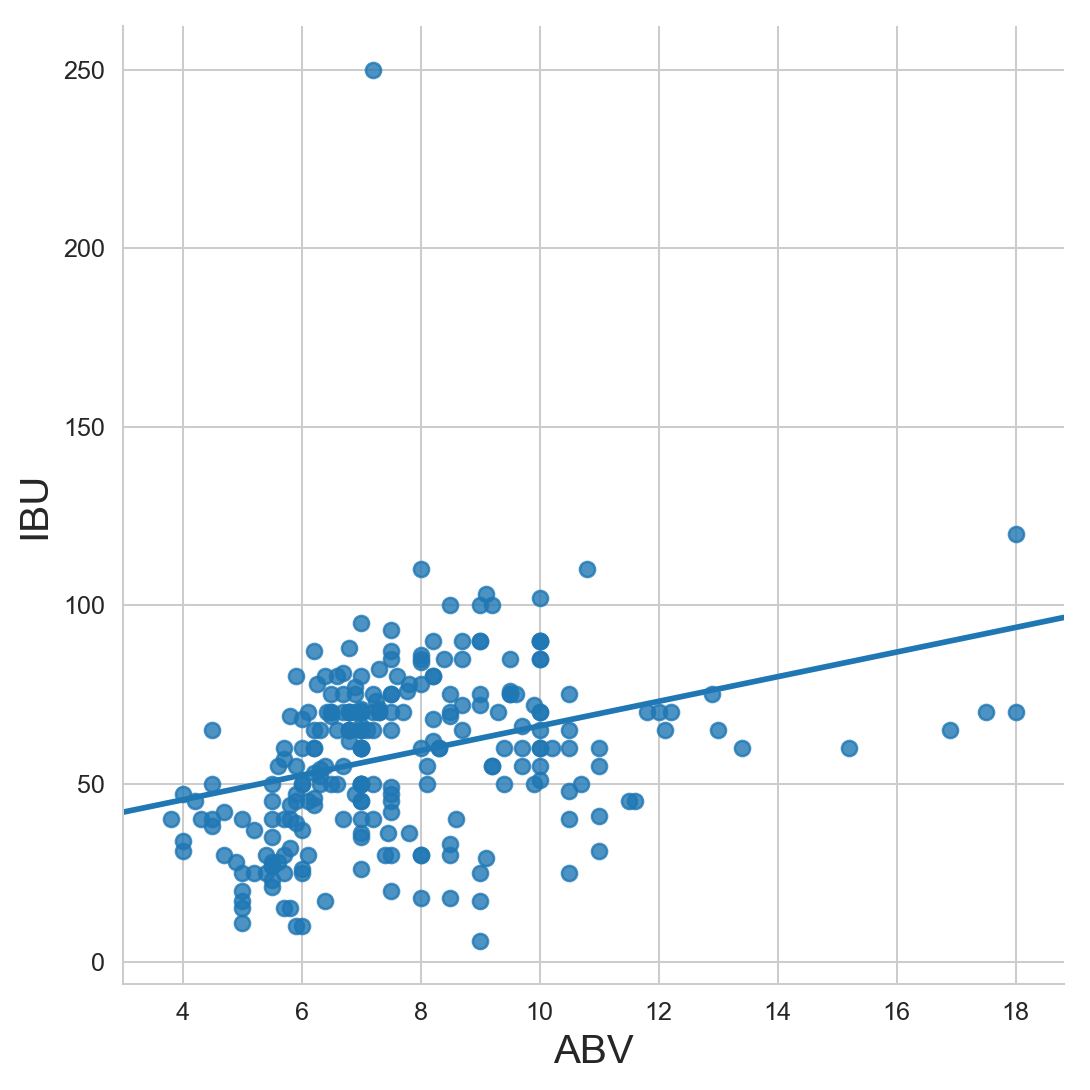

In [20]:
# First plot a normal regression of ibu on abv
sns.lmplot(data = beers_train, x="ABV", y="IBU", 
           height=6, ci = False)

plt.xlabel("ABV", fontsize=16)
plt.ylabel("IBU", fontsize=16)

plt.show()

<IPython.core.display.Javascript object>


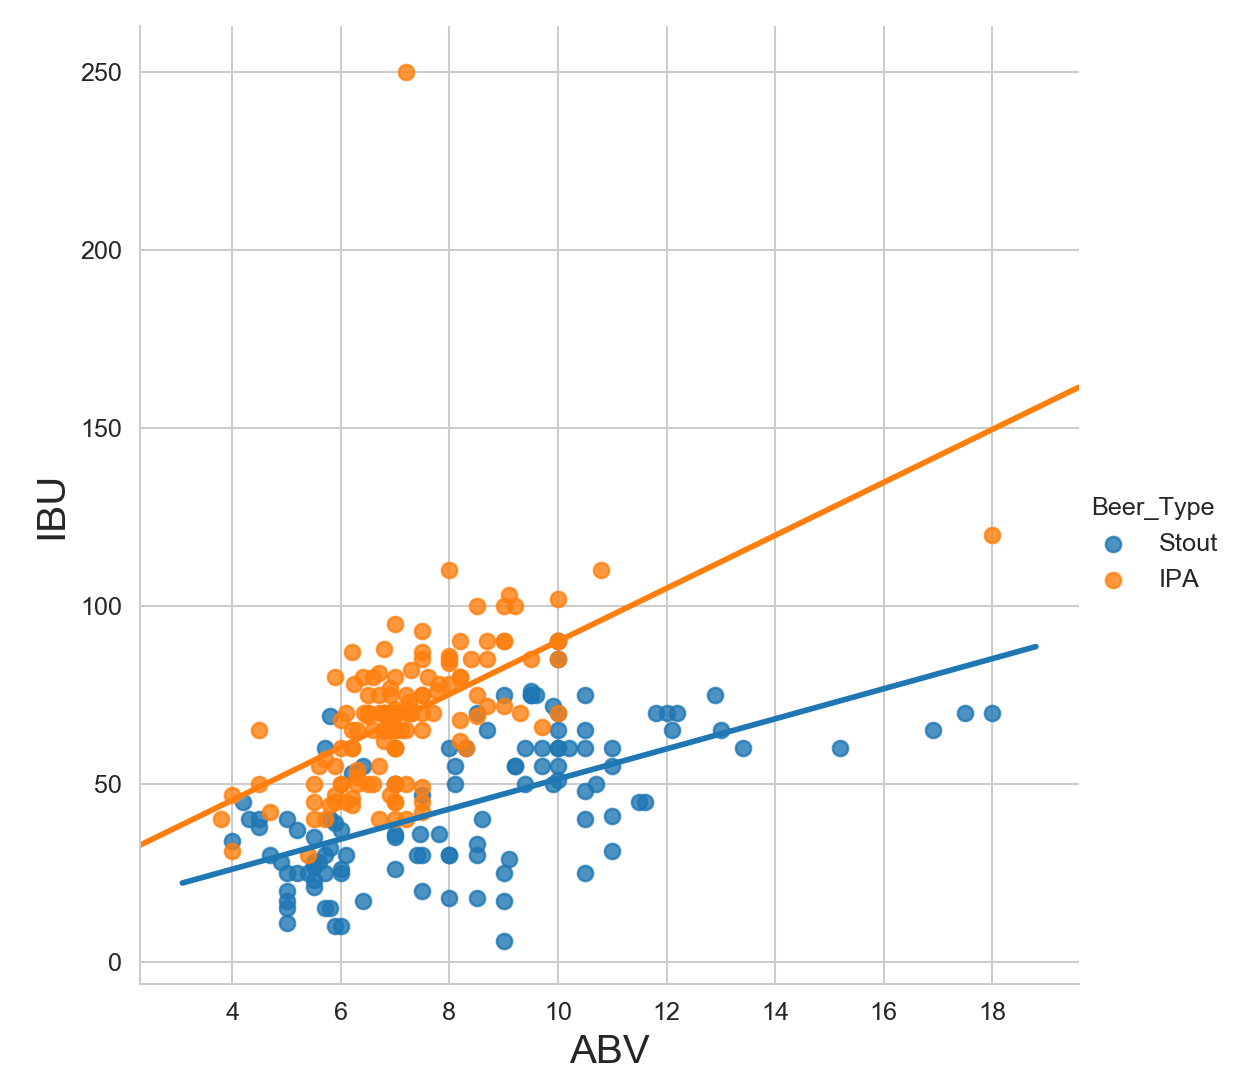

In [21]:
# now plot a regression with "hue" listed as Beer_Type
sns.lmplot(data = beers_train, x="ABV", y="IBU", 
           hue = "Beer_Type", height=6,  
           ci = False)

plt.xlabel("ABV", fontsize=16)
plt.ylabel("IBU", fontsize=16)

plt.show()

So the idea is that while there may exist a linear relationship between `ABV` and `IBU`, it is possible that the exact relationship is different based on the type of beer you're looking at.

Making a `lmplot` is one way to see if there is an effect from a qualitative variable, but it isn't always feasible, especially with a lot of possible qualitative values. Another way to probe for an effect is with a box and whisker plot.

<IPython.core.display.Javascript object>


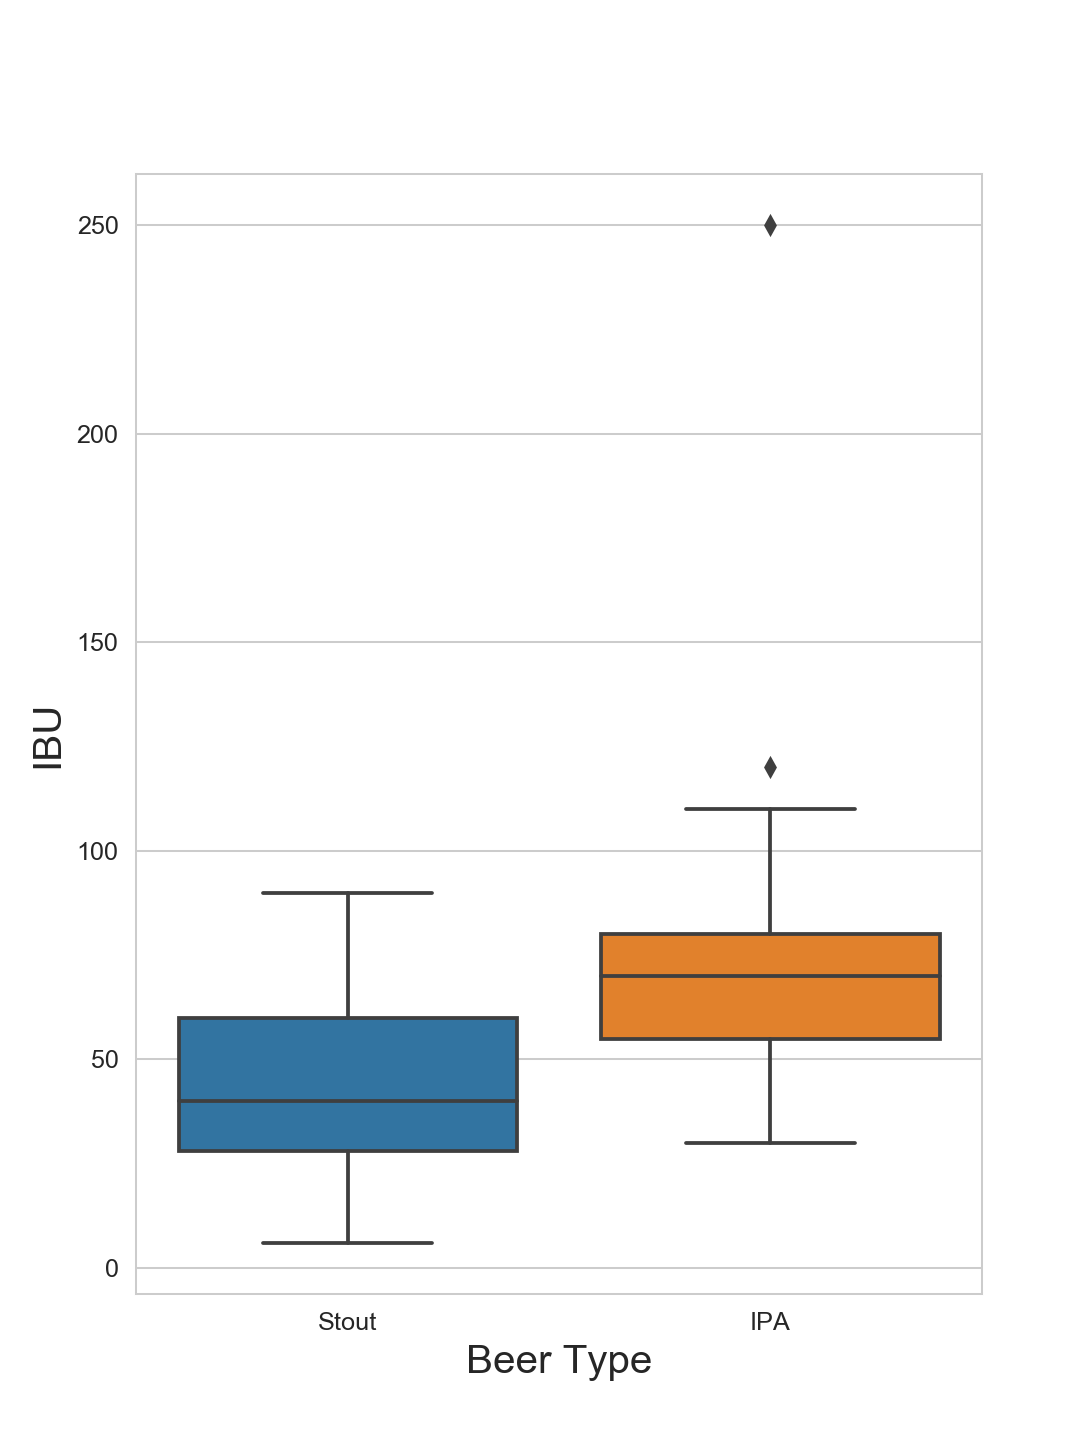

In [22]:
# We'll use seaborn to make this
fig,ax = plt.subplots(figsize=(6,8))

# boxplot takes in the data, the x-axis variable, the y-axis variable
# and produces a box and whisker plot
sns.boxplot(data = beers_train,x = "Beer_Type",y = "IBU",ax=ax)

plt.xlabel("Beer Type", fontsize = 16)
plt.ylabel("IBU", fontsize = 16)

plt.show()

A box plot is a way of showing the distribution of a continuous variable. The bottom of each box shows the $25^\text{th}$ percentile of the distribution, the middle line shows the median of the distribution, and the $75^\text{th}$ percentile of the distribution. 

For the `beers` data our plot shows that the distribution of `IBU` is slightly different by `Beer_Type`. Giving more evidence that we may want to include `Beer_Type` as a qualitative feature in the model.


### How to Include Qualitative Features - One-Hot Encoding

We cannot just include the `Beer_Type` variable in the model like `reg.fit(beers_train[['ABV','Beer_Type']],beers_train['IBV'])` because our features must be numeric not strings. So we must change our strings into numbers. The way this is done in general is called <i>one-hot encoding</i>.

#### How to One-Hot Encode

In general suppose your qualitative variable, $Q$, has $k$ possible values. In our example $k = 2$. Then you create $k-1$ new indicator variables,
$$
1_{l,i} = \left\lbrace \begin{array}{c c}
    0 & \text{if } Q_i \neq l \\
    1 & \text{if } Q_i = l
\end{array} \right.,
$$
for $l$ being any of the first $k-1$ $k$ possible values, and where $i$ denotes the $i^\text{th}$ observation in the data set. By the process of elimination if each of the $k-1$ $1_l$ are $0$ then the value of $Q$ must be the $k^\text{th}$ possible value.

So for our `beers` data we would create a `Stout` indicator that is $1$ if the beer is a `Stout` and $0$ if not.

Let's see how to create this in `python`.

In [23]:
# We can do it by hand
# First set all beers as 0
beers_train['Stout'] = 0

# Then locate all the stouts and set Stout to 1
beers_train.loc[beers_train.Beer_Type == "Stout",'Stout'] = 1

In [24]:
beers_train.head(10)

,Beer_Name,IBU,ABV,Rating,Beer_Type,Stout
54,Shakespeare Oatmeal Stout,60,5.7,3.722,Stout,1
3,Dragon’s Milk,31,11.0,4.062,Stout,1
281,Road 2 Ruin Double IPA,78,8.0,3.836,IPA,0
292,Hercules Double IPA,85,10.0,3.831,IPA,0
345,White Rajah,70,6.8,4.015,IPA,0
339,The Immortal IPA,54,6.3,3.679,IPA,0
205,Pineapple Sculpin,70,7.0,3.798,IPA,0
66,Brewer's Reserve Bourbon Barrel Stout,48,10.5,4.201,Stout,1
82,Cocoa Psycho,85,10.0,3.943,Stout,1
132,Stochasticity Project: Master of Disguise,55,9.7,3.834,Stout,1


In [25]:
# By hand is easy for a binary option, but
# tedious for variables with many categories
# in that case pandas.get_dummies is useful
pd.get_dummies(beers_train['Beer_Type'])

# For us we'd only keep the `Stout` column
beers_train['Stout'] = pd.get_dummies(beers_train['Beer_Type'])['Stout']

In [26]:
beers_train.head(10)

,Beer_Name,IBU,ABV,Rating,Beer_Type,Stout
54,Shakespeare Oatmeal Stout,60,5.7,3.722,Stout,1
3,Dragon’s Milk,31,11.0,4.062,Stout,1
281,Road 2 Ruin Double IPA,78,8.0,3.836,IPA,0
292,Hercules Double IPA,85,10.0,3.831,IPA,0
345,White Rajah,70,6.8,4.015,IPA,0
339,The Immortal IPA,54,6.3,3.679,IPA,0
205,Pineapple Sculpin,70,7.0,3.798,IPA,0
66,Brewer's Reserve Bourbon Barrel Stout,48,10.5,4.201,Stout,1
82,Cocoa Psycho,85,10.0,3.943,Stout,1
132,Stochasticity Project: Master of Disguise,55,9.7,3.834,Stout,1


Now we are ready to fit the following model:
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon
$$

In [27]:
# We'll use sklearn
reg = LinearRegression(copy_X = True)

# fit the model
reg.fit(beers_train[['ABV','Stout']],beers_train['IBU'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))

beta_0_hat is 32.63203
beta_1_hat is 5.08177
beta_2_hat is -30.63135


In [29]:
# We can plot the two lines by limiting our prediction input
stout_values = np.ones((100,2))
stout_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)

# make a stout prediction
stout_pred = reg.predict(stout_values)

# make ipa values
ipa_values = np.zeros((100,2))
ipa_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)
ipa_pred = reg.predict(ipa_values)

<IPython.core.display.Javascript object>


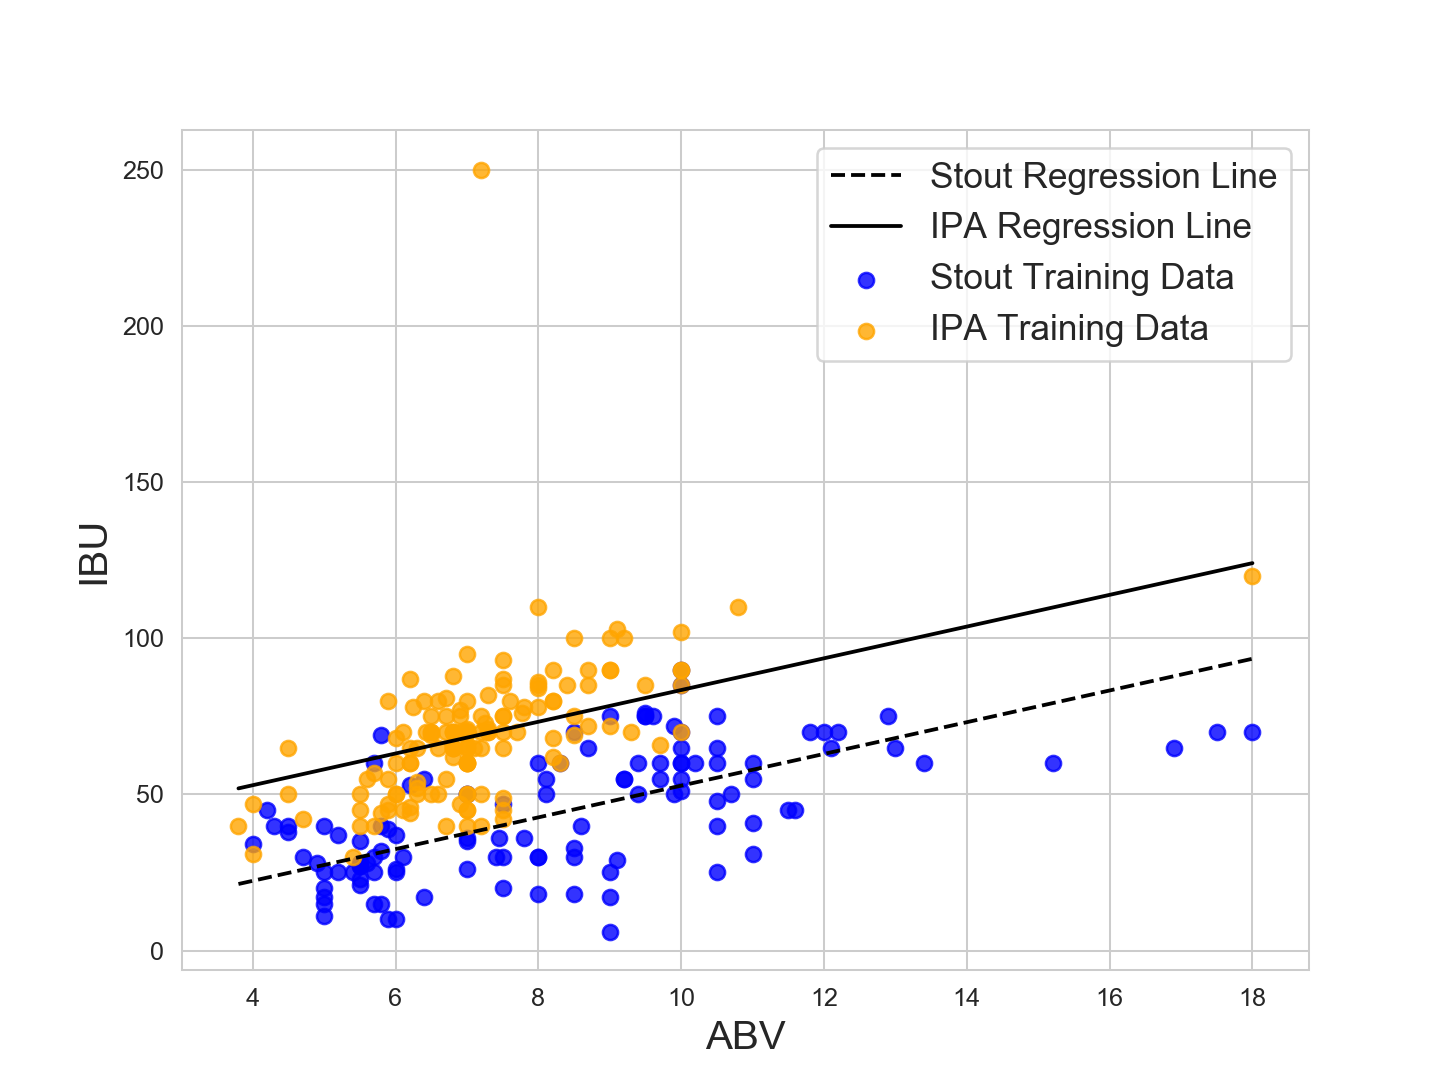

In [30]:
# Let's plot
plt.figure(figsize=(8,6))

# plot stout values
plt.scatter(beers_train.loc[beers_train.Stout == 1,'ABV'], 
               beers_train.loc[beers_train.Stout == 1,'IBU'],
               c = 'blue', alpha = .8, label="Stout Training Data")

# plot the stout line
plt.plot(stout_values[:,0], stout_pred, "k--", label="Stout Regression Line")

# plot ipa values
plt.scatter(beers_train.loc[beers_train.Stout == 0,'ABV'], 
               beers_train.loc[beers_train.Stout == 0,'IBU'],
               c = 'orange', alpha = .8, label="IPA Training Data")

# plot the ipa line
plt.plot(ipa_values[:,0], ipa_pred, "k", label="IPA Regression Line")

plt.legend(fontsize = 14)

plt.xlabel("ABV",fontsize=16)
plt.ylabel("IBU",fontsize=16)

plt.show()

### Why isn't My Line the Same?

Now notice, this is NOT the line we produced above with the the `sns.lmplot` command. That's because we have not included the interaction between `ABV` and `Stout`. We'll return to this dataset in Notebook 4 and include the interaction term.

#### A Better Explanation - Look at the Model

Recall our model
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon.
$$

When Stout $=0$ the intercept for our line is $\beta_0$. When Stout $=1$ the intercept becomes $\beta_0 + \beta_1$. But, notice in either case the slope of the line stays the same, $\beta_1$. If you look back at the `seaborn` plot we produced, the lines do not have the same slope. So clearly our statistical model is missing something that the `seaborn` model has. As I said before, we'll see what that something is in Notebook 4.

## Questions

<br>
<br>
<br>
<br>
<br>

## End Question Time

## Practice!

Take your model for the `carseats` data from earlier. Examine the feature labeled `ShelveLoc`. Does it appear that this qualitatve variable has an impact on `Sales`? Add this feature to the model you made earlier in the notebook.

In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















## How to Choose the Best Model

So now that we understand MLR better, there are a number of models we could build. With the techniques we've touched on so far a data set with $m$ features has $2^m$ possible models.

It is natural to think about how we should go about choosing the best predictive model.

As we've discussed before we can't just choose the model that performs the best on our training data because we could just arbitrarily make a model that fits each training point to its target value.

We may also be tempted to see which model performs best on the test set we made, but this has a similar problem. We'll just be producing models that perform really well on the test set.

So what to do?

### Cross-Validation

Enter $k$-fold cross-validation.

The idea behind this technique is pretty clever.

Because the data we have is random, the algorithm we use is a random process. So the value of the loss function on testing data is an example of a random variable, let's call this random variable $Q$.

It would be nice to know something about the distribution of $Q$, but this is tricky with a finite amount of data. However, we can leverage a popular theorem from probability theory called the law of large numbers (see the probability theory and statistics cheat sheet).

If we were able to generate a bunch of random draws of $Q$, say $k$ random draws, then the law of large numbers says that:
$$
\frac{1}{k}\sum_{i=1}^k Q_i \approx E(Q),
$$
assuming our random draws were independent.

So in $k$-fold cross-validation we take our training set, and randomly split it into $k$ equally sized chunks. For each chunk we train the algortihm on the $k-1$ other chunks and then calculate the testing loss using the chunk we left out. Then we take the arithmetic mean of all $k$ testing errors. This is an approximation of the expected value of the true generalization error of the algorithm.

Here's a picture to help illustrate the idea for $5$-fold cross-validation:
<img src="CV_pic.png" style="width:80%"></img>

Let's see how this works in `sklearn` to help us choose the best model for the `Advertising` data.


In [31]:
# import the KFold object from sklearn
from sklearn.model_selection import KFold

# We'll need this when we fit models
from sklearn.base import clone

In [32]:
# Now we make a kfold object
# we'll use 5 splits
# and shuffle the data before making the splits
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

In [33]:
# To make this simpler I make my data
# into an array
X = np.array(ads_train[['TV','radio']])
y = np.array(ads_train['sales'])

# You can loop through all the splits like so
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  3   4   5   6   7   8   9  10  11  12  13  15  17  18  19  20  21  22
  23  24  25  26  27  28  29  31  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  49  50  51  53  55  56  57  60  61  62  63  64  65
  67  68  69  70  71  72  73  74  75  77  79  81  82  83  84  85  86  87
  88  89  91  92  93  95  97 100 101 102 105 107 108 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 128 129 130 131 133 134 135
 136 137 138 140 141 142 143 144 145 146 147 149] TEST: [  0   1   2  14  16  30  32  48  52  54  58  59  66  76  78  80  90  94
  96  98  99 103 104 106 109 126 127 132 139 148]
TRAIN: [  0   1   2   4   5   6   8   9  10  11  12  13  14  15  16  18  21  22
  24  25  26  27  28  29  30  32  34  35  37  39  40  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  58  59  60  61  62  64  65  66
  67  68  69  70  73  75  76  77  78  80  81  82  83  84  85  86  87  88
  90  93  94  95  96  97  98  99 101 102 103 104 105 106 109 110 111 112
 113

In [34]:
# Now let's put it all together.
# It will be easier for us to make a couple functions
# to loop through all 8 possible models

# This gets our data for us
def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

# this calculates the mse
def get_mse(model, X, y):
    # get the prediction
    pred = model.predict(X)
    
    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)

In [35]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]

powerset_no_empty(['TV','radio','newspaper'])


[['TV'],
 ['radio'],
 ['TV', 'radio'],
 ['newspaper'],
 ['TV', 'newspaper'],
 ['radio', 'newspaper'],
 ['TV', 'radio', 'newspaper']]

In [36]:
possible_features = powerset_no_empty(['TV','radio','newspaper'])

In [37]:
# Now make an array that will hold the mses
# for all the models
# the columns represent each possible model
MSEs = np.empty((5,len(possible_features)))

In [38]:
# Make a regression model
reg = LinearRegression(copy_X = True)

In [39]:
# For each possible model
for j in range(len(possible_features)):
    # get X and y
    X, y = get_X_y(ads_train, possible_features[j], 'sales')

    # keep track of what split we're on
    i = 0
    
    # Perform CV
    for train_index, test_index in kfold.split(X):
        # Get the cv train test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Cloning the regression makes a fresh regression 
        # model for each run
        clone_reg = clone(reg)
        
        # fit the model
        clone_reg.fit(X_train,y_train)
        
        MSEs[i,j] = get_mse(clone_reg, X_test, y_test)
        
        i = i + 1

In [40]:
# Here are the MSEs
MSEs

array([[10.45349694, 25.89255369,  3.42614468, 38.06769672, 11.40099804,
        26.06179983,  3.46317853],
       [ 9.71572054, 17.44793455,  2.04434287, 26.42582728,  7.5302255 ,
        17.45154021,  2.05566141],
       [12.21872735, 16.02296025,  4.3957273 , 24.27057911, 10.47995636,
        16.09505964,  4.47561529],
       [ 9.56393218, 15.10069217,  1.73921495, 28.13847369,  9.36276767,
        15.9896412 ,  1.7485408 ],
       [13.74114649, 14.16516924,  2.28195035, 18.337289  , 14.08671111,
        13.8456363 ,  2.50241955]])

In [41]:
# We can get the mean MSEs using np.mean
# axis = 0 tells np.mean to take the column mean
# we can get where the min occurs with argmin
np.argmin(np.mean(MSEs, axis = 0))

2

In [42]:
print("The model with the lowest mean CV MSE",
     "was the one with", possible_features[np.argmin(np.mean(MSEs, axis = 0))],
     "as the features. This model had a mean CV MSE of",
     np.round(np.min(np.mean(MSEs, axis=0)),5))

The model with the lowest mean CV MSE was the one with ['TV', 'radio'] as the features. This model had a mean CV MSE of 2.77748


In [43]:
# Another popular measure is root mse
# this is because it has the same dimension as 
# the target variable

# It can be interpreted as how far off we were from the
# true value on average
np.round(np.min(np.sqrt(np.mean(MSEs, axis = 0))),5)

1.66658

Here we brute forced our way through all the models because there were only eight possible models. There are two other algorithms we touch on in the HW called backwards and forwards selection that are greedy algorithms. The benefit of these approaches is that they run more quickly than brute force, the problem is that they might not give you the "best model".

The brute force approach was feasible because we had a small number of predictors, and an okay number of observations. 

This really doesn't work when your data has a large number of predictors (there are too many models to check, and you need a large quantity of samples to fit models with a lot of predictors this is known as the curse of dimensionality), or if you have a small sample size (makes it difficult to split your data even further). We'll learn other techniques for model selection in those cases later on. Also in many cases it doesn't make sense to even include a predictor in the model, for example because it has no association with your target.

For now we'll stick to examining correlations, scatter plots to provide plausible features, and then use cross validation to pick the best subset of those plausible features.


## Question Break

Let's go ahead and answer a couple questions, then we'll have you guys build the best `carseats` model you can in a breakout session.

<br>
<br>
<br>
<br>
<br>
<br>

## Questions Break Over

## Practice

Go ahead and try to build the best model you can to predict `carseat` `sales`, using the techniques from the first three notebooks.

In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















In [ ]:
## Code here
















## See you in Notebook 4!

That's it for Notebook 3. Next we'll be learning about how to include higher dimensional and nonlinear terms to the linear regression framework.